In [1]:
import numpy as np
import torch
from torch import optim, nn
from collections import OrderedDict
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Initialization

In [2]:
batch_size = 64
print_every = 10
epochs = 2
lr = 0.0001
CRUP_DIMENSION = (224, 224)
MEANS = [0.485, 0.456, 0.406]
STANDARD_DEVIATIONS = [0.229, 0.224, 0.225]

### set Device

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda:0


# Load Data

In [4]:
dataset_dir = 'Datasets/Chest X-Ray/'
train_dir = dataset_dir + 'train/'
test_dir = dataset_dir + 'test/'
valid_dir = dataset_dir + 'val/'

In [5]:
train_transforms = transforms.Compose([
                        transforms.RandomRotation(10),
                        transforms.RandomResizedCrop(CRUP_DIMENSION),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
                    ])
valid_transforms = transforms.Compose([
                        transforms.RandomRotation(10),
                        transforms.RandomResizedCrop(CRUP_DIMENSION),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
                    ])
test_transforms = transforms.Compose([
                        transforms.RandomRotation(10),
                        transforms.RandomResizedCrop(CRUP_DIMENSION),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize(MEANS, STANDARD_DEVIATIONS)
                    ])

# Load the Datasets with ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)


# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [6]:
train_class_idx = train_dataset.class_to_idx
valid_class_idx = valid_dataset.class_to_idx
test_class_idx = test_dataset.class_to_idx

# Plot Sample Data

In [7]:
def plot_data(tensor, tensor_class_idx, count=1, normalize=True):
    images, labels = next(tensor)
    a = np.floor(count**0.5).astype(int)
    b = np.ceil(1.*count/a).astype(int)
    fig = plt.figure(figsize=(4.*b,4.*a))
    for i in range(1, count+1):
        ax = fig.add_subplot(a,b,i)
        ax.plot(images[i].numpy()[:,0,0])
        forDisplay = images[i].numpy().transpose((1, 2, 0))
        
        if normalize:
            mean = np.array(MEANS)
            standard_deviation = np.array(STANDARD_DEVIATIONS)
            forDisplay = standard_deviation * forDisplay + mean
            forDisplay = np.clip(forDisplay, 0, 1)
        ax.imshow(forDisplay)
        
        ax.set_title({val: key for key, val in tensor_class_idx.items()}[labels[i].item()])
        ax.set_axis_off()

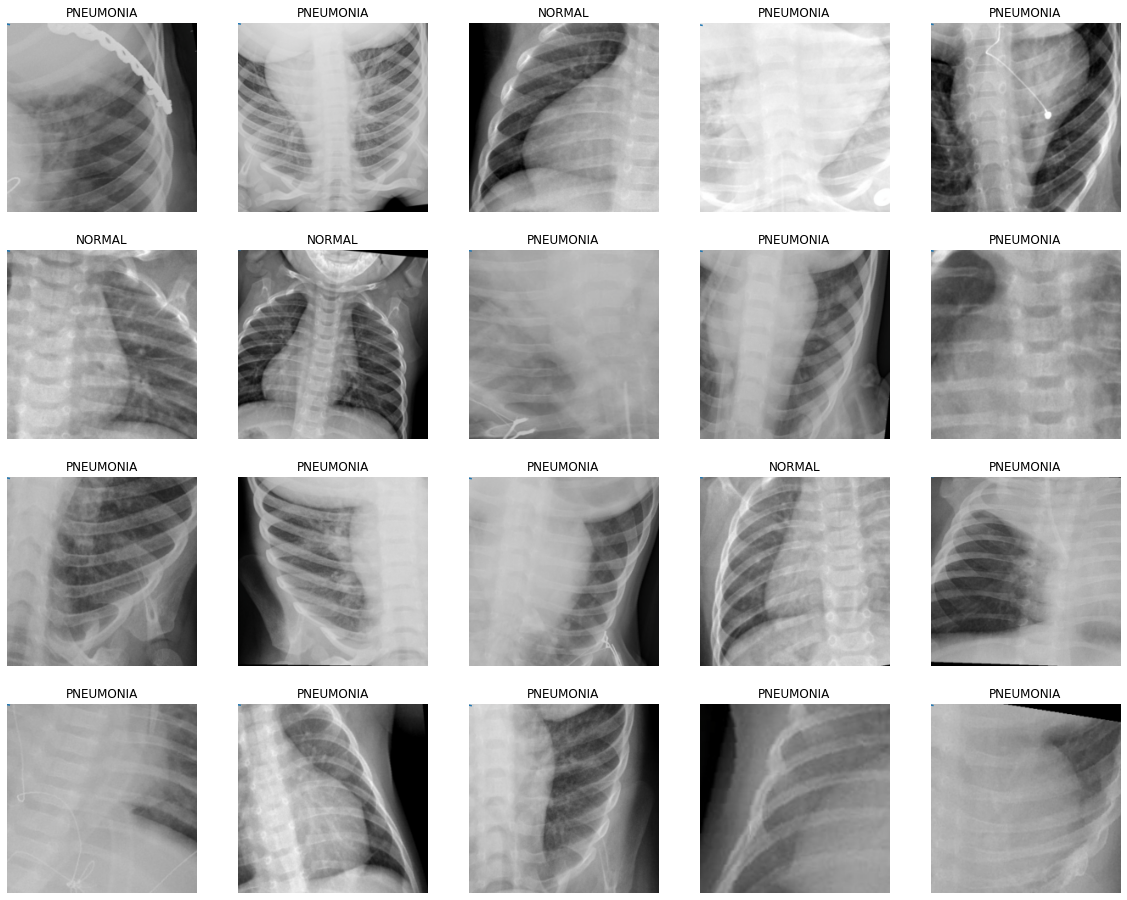

In [8]:
plot_data(iter(train_loader), train_class_idx, count=20)

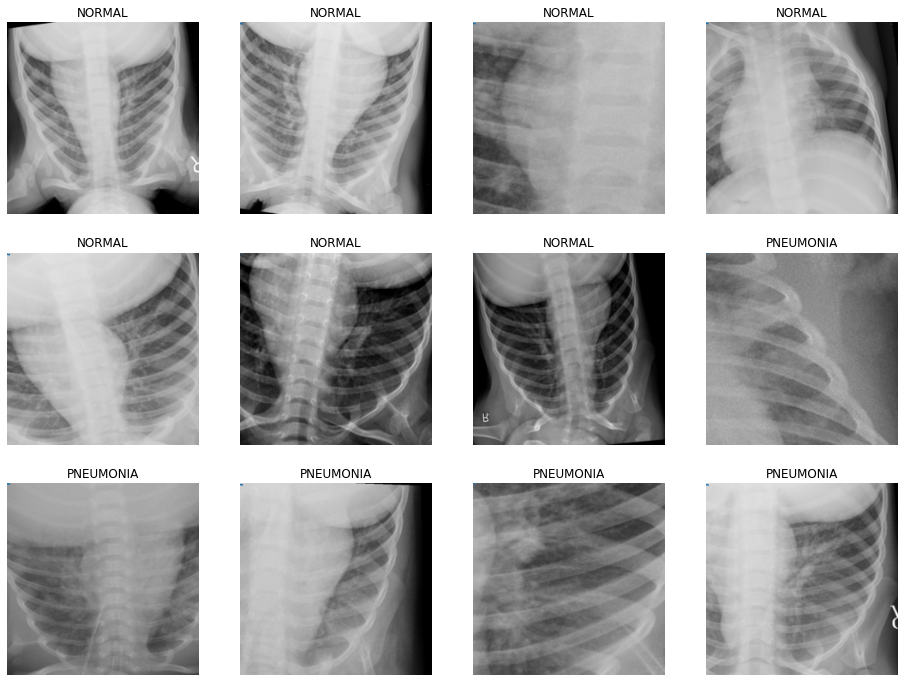

In [9]:
plot_data(iter(valid_loader), valid_class_idx, count=12)

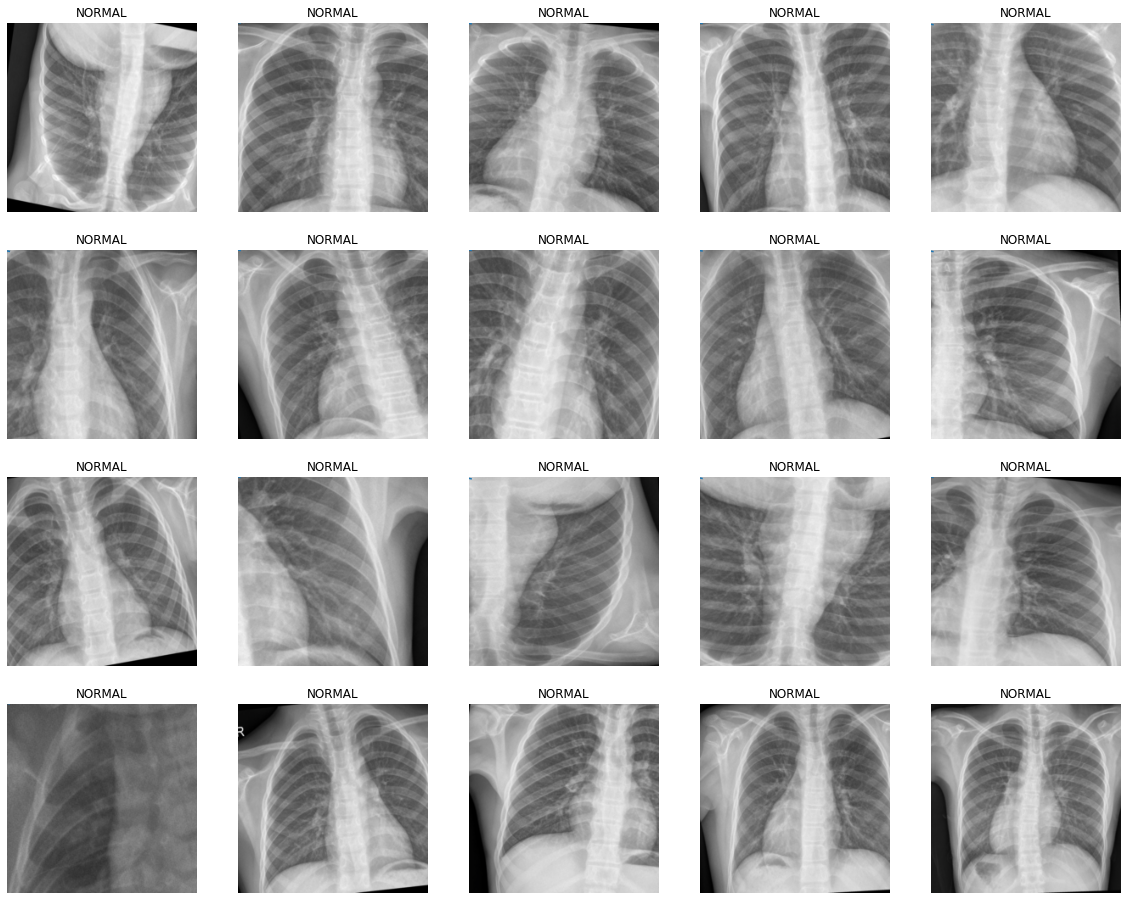

In [10]:
plot_data(iter(test_loader), test_class_idx, count=20)

# Chest X-Ray (AlexNet) Model

In [11]:
model = getattr(models, 'alexnet')(pretrained=True)

classification_input_changel = model.classifier._modules['1'].in_features

# Freeze Backbone Layers
for param in model.parameters():
    param.requires_grad = False

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
model.classifier = nn.Sequential(OrderedDict([
    ('0', nn.Linear(classification_input_changel, 512)),
    ('1', nn.Dropout(p=0.2)),
    ('2', nn.ReLU()),
    ('3', nn.Linear(512, 128)),
    ('4', nn.Dropout(p=0.2)),
    ('5', nn.ReLU()),
    ('6', nn.Linear(128, 64)),
    ('7', nn.Dropout(p=0.2)),
    ('8', nn.ReLU()),
    ('9', nn.Linear(64, 32)),
    ('10', nn.Dropout(p=0.2)),
    ('11', nn.Linear(32, 2)),
    ('12', nn.LogSoftmax(dim= 1))
]))
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=512, bias=True)
    (1): Dropout(p=0.2, inplace=False)
  

In [13]:
loss_function = nn.NLLLoss()
learning_rate = 0.003
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [14]:
def train_XRay(model, training_dataset, validation_dataset, loss_function, optimizer, epochs, print_every, device):
    # Set model to appropriate device
    model.to(device)

    batch_size = training_dataset.batch_size

    # Print training overview messages
    print("Training on %s" % device)
    print("%s batchs of %s images per batch" % (len(training_dataset.batch_sampler) * epochs, batch_size))
    print("Average loss and accuracy will display every %s batches\n" % print_every)


    train_losses = []
    validation_losses = []
    validation_accuracy = []

    for epoch in range(epochs):
        print("Working on Epoch: %s/%s" % (epoch+1, epochs))
        print("---------------------------------------")

        epoch_loss = 0
        model.train()

        for batch_idx, (inputs, labels) in enumerate(training_dataset):
            inputs, labels = inputs.to(device), labels.to(device)

            # Set all optimizer gradients to zero
            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss
            if (batch_idx+1) % print_every == 0:
                print("---------------------------------------")
                print("Current status Batch %s: Images %s to %s." % ((batch_idx+1), batch_size * 
                                                                  (batch_idx+1), batch_size *
                                                                  ((batch_idx+1) + 1)))
                validation_correct, validation_total, validation_loss = check_neural_network_accuracy(
                                                                                model,
                                                                                validation_dataset,
                                                                                device,
                                                                                loss_function)
                train_losses.append(epoch_loss / print_every)
                validation_losses.append(validation_loss / print_every)
                validation_accuracy.append((validation_correct / validation_total) * 100)
                print("Training Loss: {:.3f}".format(epoch_loss / print_every),
                      " - Validation Loss: {:.3f}".format(validation_loss / print_every),
                      " - Validation Accuracy: %d%%" % ((validation_correct / validation_total) * 100))                    
                epoch_loss = 0
    return train_losses, validation_losses, validation_accuracy

def check_neural_network_accuracy(model, dataset, device, criterion, correct=0, total=0):    
    print("Checking accuracy:")
    loss = 0
    model.to(device)
    model.eval()

    # Check accuracy without calculating gradient
    with torch.no_grad():
        for ii, (inputs, labels) in enumerate(dataset):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            current_loss = criterion(outputs, labels)
            # Update loss for current training
            loss += current_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    model.train()

    return correct, total, loss

In [15]:
train_losses, validation_losses, validation_accuracy = train_XRay(model,
                                                                   train_loader,
                                                                   valid_loader,
                                                                   loss_function,
                                                                   optimizer,
                                                                   epochs,
                                                                   print_every,
                                                                   device)

Training on cuda:0
164 batchs of 64 images per batch
Average loss and accuracy will display every 10 batches

Working on Epoch: 1/2
---------------------------------------
---------------------------------------
Current status Batch 10: Images 640 to 704.
Checking accuracy:
Training Loss: 0.693  - Validation Loss: 0.070  - Validation Accuracy: 50%
---------------------------------------
Current status Batch 20: Images 1280 to 1344.
Checking accuracy:
Training Loss: 0.469  - Validation Loss: 0.103  - Validation Accuracy: 62%
---------------------------------------
Current status Batch 30: Images 1920 to 1984.
Checking accuracy:
Training Loss: 0.352  - Validation Loss: 0.166  - Validation Accuracy: 62%
---------------------------------------
Current status Batch 40: Images 2560 to 2624.
Checking accuracy:
Training Loss: 0.342  - Validation Loss: 0.094  - Validation Accuracy: 56%
---------------------------------------
Current status Batch 50: Images 3200 to 3264.
Checking accuracy:
Train

# Review loss and accuracy

In [16]:
train_losses = [ float(d.to('cpu').data) for d in train_losses]
# validation_losses = [ float(d.to('cpu').data) for d in validation_losses]
# validation_accuracy = [ float(d.to('cpu').data) for d in validation_accuracy]

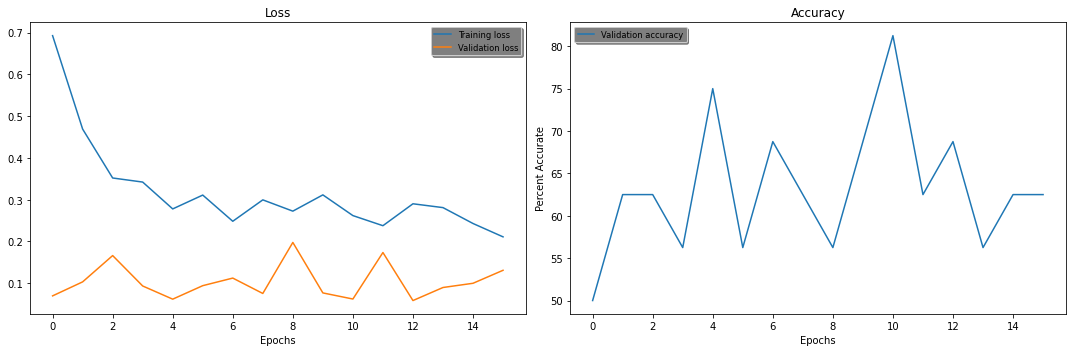

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
legend = plt.legend(loc='upper right', shadow=True, fontsize='small')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C7')

plt.subplot(1, 2, 2)
plt.plot(validation_accuracy, label='Validation accuracy')
plt.title('Accuracy')
plt.ylabel('Percent Accurate')
plt.xlabel('Epochs')
legend = plt.legend(loc='upper left', shadow=True, fontsize='small')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C7')
plt.tight_layout()

# Test Model

In [19]:
test_correct, test_total, test_loss = check_neural_network_accuracy(model, test_loader, device, loss_function)
print("Test Loss: {:.3f}".format(test_loss), " - Test Accuracy: %d%%" % ((test_correct / test_total) * 100)) 

Checking accuracy:
Test Loss: 5.233  - Test Accuracy: 83%


In [21]:
train_correct, train_total, train_loss = check_neural_network_accuracy(model, train_loader, device, loss_function)
print("Train Loss: {:.3f}".format(train_loss), " - Train Accuracy: %d%%" % ((train_correct / train_total) * 100))


Checking accuracy:
Train Loss: 19.976  - Train Accuracy: 90%


# Save Model

In [ ]:
torch.save(model.state_dict(), 'output/x-ray.pat')

# Load Model

In [ ]:
model = Chest_XRay()
model.load_state_dict(torch.load('output/x-ray.pat'))
model.eval()

# Test After Load

In [ ]:
test_correct, test_total, test_loss = model.check_neural_network_accuracy(test_loader, device, loss_function)
print("Test Loss: {:.3f}".format(test_loss), " - Test Accuracy: %d%%" % ((test_correct / test_total) * 100)) 